### Notebook that reads the output of FMDeg from TCGA dataset and visualize the scatter plot of the output

### Read data 

In [11]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import statsmodels.stats.multitest as mt

### paths

In [12]:
base_output = "../../../data/output_methods_selection/"
output_path = os.path.join(base_output,"output_smdeg_degrons_paper_ccle_predicted_tri")
base="../../../" 
# Path degrons
path_regions = os.path.join(base,"data","coordinates_degrons.tsv.gz")
path_all_degrons = os.path.join(base,"data","predicte_degrons_properties.tsv.gz")
# Path mutations CCDS
path_output_missense_degrons = os.path.join(base,"data","missense_clean_type_ccle.tsv.gz")
# Outputs
path_output_all = os.path.join(base,"data","smdeg_degrons_ccle_tri.tsv")
# Role data
role_data = os.path.join(base,"external","gene_MoA.tsv")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure5")

# Aux functions

In [13]:
def load_deg(regex,globf):
    p = re.compile(regex)#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_([A-Z]+)-oncodrivefml.tsv"
    l = []
    for filef in glob.glob(globf):#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_*-oncodrivefml.tsv"
        
        ttype = re.search(p,filef).group(1)

        df = pd.read_csv(filef,sep="\t")

        df["Cancer_Type"] = ttype
        
        df.rename(columns={"ENSEMBLT":"Hugo_Symbol","REGION":"GENE_ID"},inplace=True)
        
        if df.shape[0] >0:
            #print (filef)
            df=df[(np.isfinite(df["P_VALUE"]))&(df["MEAN_SIMULATED"]>0)&(df["OBSERVED_REGION"]>2)] # not an error
            if df.shape[0] > 0:
                df["DEGRON"] = df.apply(lambda row: row["GENE_ID"].split(":")[1],axis=1)
                df["Entry_Isoform"] = df.apply(lambda row: row["GENE_ID"].split(":")[0],axis=1)
                df["STARTF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[2]),axis=1)
                df["STOPF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[3]),axis=1)
                #df["Q_VALUE"]=mt.fdrcorrection(df["P_VALUE"],alpha=0.05)[1]
                l.append(df)
    df_total = pd.concat(l)
    return df_total

def match_df_degrons(df_output):
   
    df_regions_info = pd.read_csv(path_regions,sep="\t",compression="gzip")
    df_degrons = pd.read_csv(path_all_degrons,sep="\t",compression="gzip")
    df_regions_info.START_FLANKING = df_regions_info.START_FLANKING.astype(int)
    df_regions_info.END_FLANKING = df_regions_info.END_FLANKING.astype(int)
    df_regions_info.START = df_regions_info.START.astype(int)
    df_regions_info.END = df_regions_info.END.astype(int)
    df_fml = pd.merge(left=df_regions_info[["Entry_Isoform","DEGRON","START_FLANKING","END_FLANKING","START","END"]],right=df_output,left_on=["Entry_Isoform","DEGRON","START_FLANKING","END_FLANKING"],right_on=["Entry_Isoform","DEGRON","STARTF","STOPF"])
    df_fml = pd.merge(left=df_fml,right=df_degrons,how="left")
    # Only retain the CCDS of mutatiions from TCGA
    df_data = pd.read_csv(path_output_missense_degrons,sep="\t",compression="gzip")
    df_fml_degron = pd.merge(df_fml,df_data[["CCDS","Entry_Isoform"]].drop_duplicates())
    return df_fml_degron
def get_smdeg():
    df = load_deg(output_path+"/([A-Z]+)-smdeg.tsv",output_path+"/*-smdeg.tsv")
    return match_df_degrons(df)
def get_odd_ratio(row):
    a = (row["OBSERVED_REGION"])
    b =  (row["TOTAL_MUTS_GENE"] - row["OBSERVED_REGION"]) 
    c =  (row["MEAN_SIMULATED"] )
    d =  (row["TOTAL_MUTS_GENE"] - row["MEAN_SIMULATED"])
    if (b==0):
        return a
    elif (c==0) or (d==0):
        return np.nan
    return (a/b) / (c/d)
def set_color(row,colors):
    if row["Cancer_Type"] in colors:
        return colors[row["Cancer_Type"]]
    else:
        return "black"

# Read SMDeg

### We defined as significant:
-- Tumor types:  effect_size > 1 and Q_VALUE <0.01



In [14]:
df_sm_degron_ttype = get_smdeg()
df_sm_degron_ttype["P_VALUE_SIM_CCLE"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["P_VALUE"]))),axis=1)
df_sm_degron_ttype["Q_VALUE_SIM_CCLE"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["Q_VALUE"]))),axis=1)
df_sm_degron_ttype["ODD_RATIO"] = df_sm_degron_ttype.apply(lambda row: get_odd_ratio(row),axis=1) 
df_sm_degron_ttype["log2(ODD_RATIO)"] = 1+np.log2(df_sm_degron_ttype["ODD_RATIO"])
df_sm_degron_ttype["effect_size_sm"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((np.log2((row["OBSERVED_REGION"]/row["MEAN_SIMULATED"])+1)))),axis=1)
df_sm_degron_ttype["log_pvalue_sm"] = df_sm_degron_ttype.apply(lambda row: -np.log10(row["P_VALUE_SIM_CCLE"]),axis=1)
df_sm_degron_ttype["log_qvalue_sm"] = df_sm_degron_ttype.apply(lambda row: -np.log10(row["Q_VALUE_SIM_CCLE"]),axis=1)
df_sm_degron_ttype.drop(columns=["P_VALUE","Q_VALUE","ODD_RATIO"],inplace=True)
df_sm_degron_ttype["significant_SM"] = df_sm_degron_ttype.apply(lambda row: True if row["effect_size_sm"]>1 and row["OBSERVED_REGION"]>2 and row["Q_VALUE_SIM_CCLE"] < 0.01 else  False,axis=1)

### We are only interested in effect sizes >= 1

In [15]:
df_sm_degron_ttype = df_sm_degron_ttype[df_sm_degron_ttype["effect_size_sm"]>=1]

### Save two dataframes one for all significant other significant + PPI

In [16]:
df_sm_degron_ttype[["Hugo_Symbol","Entry_Isoform","DEGRON","START","END","effect_size_sm","log_pvalue_sm","Cancer_Type","P_VALUE_SIM_CCLE","Class","significant_SM","PPI","log_qvalue_sm","Q_VALUE_SIM_CCLE","OBSERVED_REGION"]].to_csv(path_output_all,sep="\t",index=False)

### define colors

In [17]:
dict_colors = json.load(open("dict_colors.json",'r'))


# Plot sM

### Prepare plots

In [18]:
df_sm_degron_ttype["color"] = df_sm_degron_ttype.apply(lambda row:set_color(row,dict_colors),axis=1)
df_sm_degron_ttype["lw"] = df_sm_degron_ttype.apply(lambda row: 0.5 if row["PPI"] > 0.0 else 0.0,axis=1)
df_sm_degron_ttype["ed"] = df_sm_degron_ttype.apply(lambda row: "black" if row["PPI"] > 0.0 else row["color"],axis=1)
df_sm_degron_ttype["text"] = df_sm_degron_ttype["Hugo_Symbol"]

### Matplotlib

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


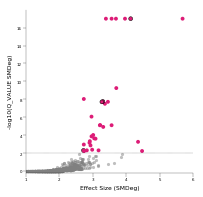

In [19]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])]
df_not_sigs = df_sm_degron_ttype[~(df_sm_degron_ttype["significant_SM"])]
limit = 16
df_sigs["log_qvalue_sm"]=df_sigs.apply(lambda row: limit +1 if row["log_qvalue_sm"]>=limit else row["log_qvalue_sm"],axis=1 )
df_sigs["text"]=df_sigs.apply(lambda row: row["text"]+"*" if row["log_qvalue_sm"]>=limit else row["text"],axis=1 )
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        #if lws[i] > 0:
            #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

# create the coordinates for the errorbars

ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
marker_size = 20
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, title='Tumor Type',markerscale=1,loc="upper left",fontsize=6)
#x=ax.legend()
# Adjust axis
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["effect_size_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (1,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])

plt.savefig(path_output_plots+'/SM_all_CCLE_tri.png', dpi=900,bbox_inches="tight")
None

### pdf (not not significant)

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


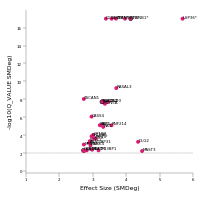

In [20]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])]
df_not_sigs = df_sm_degron_ttype[~(df_sm_degron_ttype["significant_SM"])].sample(frac=0.0)
limit = 16
df_sigs["log_qvalue_sm"]=df_sigs.apply(lambda row: limit +1 if row["log_qvalue_sm"]>=limit else row["log_qvalue_sm"],axis=1 )
df_sigs["text"]=df_sigs.apply(lambda row: row["text"]+"*" if row["log_qvalue_sm"]>=limit else row["text"],axis=1 )
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        #if lws[i] > 0:
            #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

# create the coordinates for the errorbars

ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
marker_size = 20
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, title='Tumor Type',markerscale=1,loc="upper left",fontsize=6)
#x=ax.legend()
# Adjust axis
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["effect_size_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (1,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])

plt.savefig(path_output_plots+'/SM_all_CCLE_tri.pdf', dpi=900,bbox_inches="tight")
None